TEAM 10: Eliecer Diaz

AIM: 

Dataset of validated Chest X-Ray images described and analyzed in "Deep learning-based classification and referral of treatable human diseases".
The data was split into three subsets: - 60 % train - 20 % validation - 20 % test
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
Version 2, published 2018-01-06 University of California San Diego

In [1]:
import random 
import collections
random.seed(7)
import tensorflow as tf
from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity
import matplotlib.pyplot as plt
from time import time
import tensorflow.keras.backend as k
import tensorflow.keras.callbacks as Callback
import matplotlib.pyplot as plot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [36]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found in this computer")
else:
    print("Found GPU at: {}".format(device_name))


GPU device not found in this computer


In [3]:
train_dir = r'/home/elvi/Desktop/pneumonia2/train' #'/kaggle/input/pneumonia/pneumonia2/train'
val_dir = r'/home/elvi/Desktop/pneumonia2/validation'#'/kaggle/input/pneumonia/pneumonia2/validation'
test_dir = r'/home/elvi/Desktop/pneumonia2/test'#'/kaggle/input/pneumonia/pneumonia2/test'

In [4]:
os.listdir(train_dir)

['PNEUMONIA', 'NORMAL']

In [43]:
folders = ['train', 'validation', 'test']
for i in folders:
    print(i)
    Pneu = os.listdir('/home/elvi/Desktop/pneumonia2/{}/PNEUMONIA'.format(i)) # dir is your directory path
    Norm = os.listdir('/home/elvi/Desktop/pneumonia2/{}/NORMAL'.format(i)) 
    print(len(Pneu), len(Norm), "% =", len(Pneu)/(len(Pneu) + len(Norm)))

train
2564 949 % = 0.7298605180757187
validation
855 317 % = 0.7295221843003413
test
854 317 % = 0.7292912040990607


In [5]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_datagen.flow_from_directory(
        test_dir,
        #verbose = 0,
        shuffle=False,
        target_size = (150, 150),
        batch_size = 1, #<----tensorflow documentation
        class_mode='binary')

Found 1171 images belonging to 2 classes.


In [45]:
def model_(neurones, batch): # SS: number neurons in the last dense layer, batch: batch size 
    
    #getting new metrics to calculate F1 at the end of the notebook
    Preci = tf.keras.metrics.Precision() 
    Recal = tf.keras.metrics.Recall() 
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range = 5, 
                                       horizontal_flip = True)
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        #verbose = 0,
        target_size = (150, 150),
        batch_size = batch,
        class_mode = 'binary')
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        #verbose = 0,
        target_size = (150, 150),
        batch_size = batch,
        class_mode='binary')
    
    try:
        with tf.device('/device:GPU:0'):
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("GPU/TPU IS ON")
    except:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("NOT USING GPU")

    return model, train_generator, val_generator

In [46]:
SS = [216] # neurones in the dense layer
batches = [8, 32, 64] # Batch sizes
models = {}
train_generators = {}
val_generators = {}

for ss in SS:
    for batch in batches:
        model_ss_batch = 'models_{}_{}'.format(ss, batch)  # creating the keys
        models[model_ss_batch] = model_(ss//10, batch) # appending the model to the key
        
        train_generator_ss_batch = 'train_generators_{}_{}'.format(ss, batch)  # creating the keys
        train_generators[train_generator_ss_batch] = model_(ss//10, batch) # appending the generator to the key
        
        val_generator_ss_batch = 'val_generators_{}_{}'.format(ss, batch)  # creating the keys
        val_generators[val_generator_ss_batch] = model_(ss//10, batch) # appending the model to the key       
        

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
NOT USING GPU


In [47]:
print(models.keys()) #prints keys
print(train_generators.keys()) #prints keys
print(val_generators.keys()) #prints keys

print(test_generator.n)

dict_keys(['models_216_8', 'models_216_32', 'models_216_64'])
dict_keys(['train_generators_216_8', 'train_generators_216_32', 'train_generators_216_64'])
dict_keys(['val_generators_216_8', 'val_generators_216_32', 'val_generators_216_64'])
1171


**Model Fitting**

In [ ]:
Final_models = {}
for i in range(len(models)):
    print('MODEL:',i)
    Final_model_i = 'models_{}'.format(i)  # creating the keys
    Final_models[Final_model_i] = models[list(models.keys())[i]][0].fit_generator(
        train_generators[list(train_generators.keys())[i]][1],
        steps_per_epoch = None, #3513//batches[i],#None, # = 3513 / 8
        verbose = 0,
        epochs = 2,
        validation_data = val_generators[list(val_generators.keys())[i]][1],
        validation_steps = None, #1172//batches[i] #None # = 1172 / 8
    )
    # saving the model
    #models[list(models.keys())[i]][0].save("model{}.h5".format(i))

MODEL: 0


0


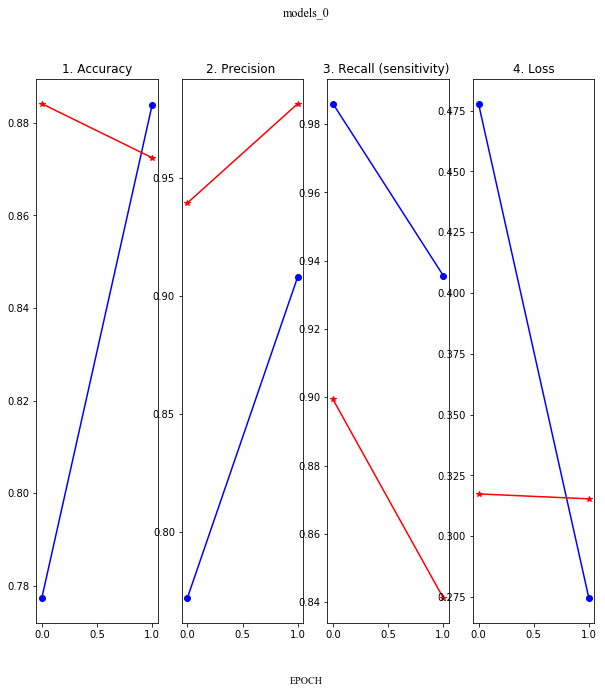

1


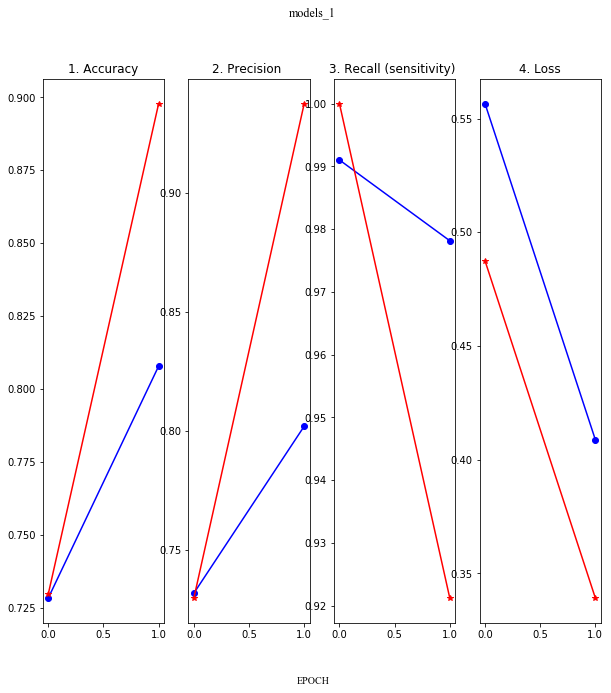

2


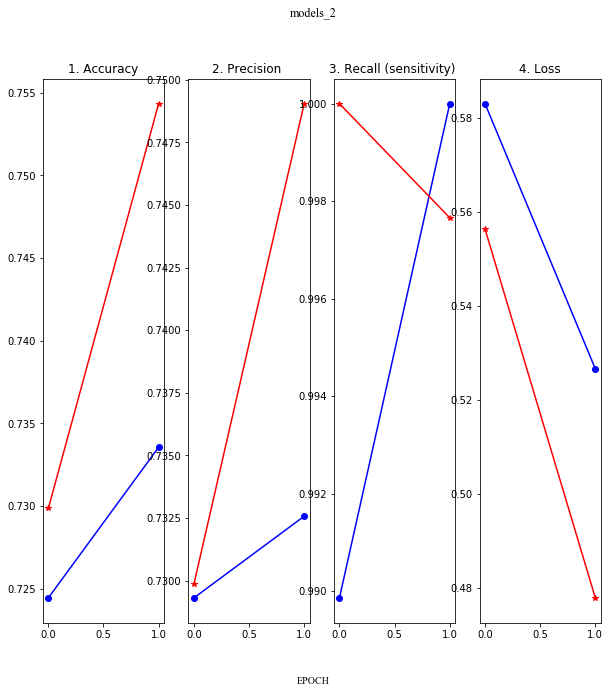

In [10]:
def fitting_eval():

    for i in range(len(Final_models)):
        print(i)
        models_key = Final_models.keys()
        model_key = [j  for  j in  models_key]
        metrics = Final_models[list(Final_models.keys())[i]].history.keys()
        metric = [k  for  k in  metrics]

        acc = Final_models[list(Final_models.keys())[i]].history[metric[1]]
        val_acc = Final_models[list(Final_models.keys())[i]].history[metric[5]]

        preci = Final_models[list(Final_models.keys())[i]].history[metric[2]]
        val_preci = Final_models[list(Final_models.keys())[i]].history[metric[6]]

        recal = Final_models[list(Final_models.keys())[i]].history[metric[3]]
        val_recal = Final_models[list(Final_models.keys())[i]].history[metric[7]]

        loss = Final_models[list(Final_models.keys())[i]].history[metric[0]]
        val_loss = Final_models[list(Final_models.keys())[i]].history[metric[4]]

        epochs = range(len(acc))

        fig, axs = plt.subplots(1, 4, figsize=(10, 10))


        axs[ 0].set_title('1. Accuracy')
        axs[ 0].plot(epochs, acc, 'bo-', label = 'Training acc')
        axs[ 0].plot(epochs, val_acc, 'r*-', label = 'Validation acc')

        axs[ 1].set_title('2. Precision ')
        axs[ 1].plot(epochs, preci, 'bo-', label = 'Precision_training ')
        axs[ 1].plot(epochs, val_preci, 'r*-', label = 'Precision validation')

        axs[ 2].set_title('3. Recall (sensitivity) ')
        axs[ 2].plot(epochs, recal, 'bo-', label = 'Recall training')
        axs[ 2].plot(epochs, val_recal, 'r*-', label = 'Recall validation')

        axs[ 3].set_title('4. Loss')
        axs[ 3].plot(epochs, loss, 'bo-', label = 'Training loss')
        axs[ 3].plot(epochs, val_loss, 'r*-', label = 'Validation loss')


        fig.suptitle(model_key[i], fontname="Times New Roman",fontweight="bold")
        fig.text(0.5, 0.04, 'EPOCH', ha='center', fontname="Times New Roman",fontweight="bold")
        plt.show()

# RESULTS

In [17]:
# RESULTS? YES...
test_generator.reset() # resetting generator
for i in range(0, len(Final_models)):
    Loss, Accuracy, Preci, Recal = models[list(models.keys())[i]][0].evaluate_generator(generator=test_generator)
    print("Model", i)
    print('Loss: {}'.format(Loss), 'Accuracy: {}'.format(Accuracy), 'Precision: {}'.format(Preci), 'Recall: {}'.format(Recal))

NameError: name 'color' is not defined

In [32]:
# Get actuall y_labels from test set
def evaluation(cutoff):

    Y_labels = test_generator.classes

    # 
    for i in range(0, len(Final_models)):
        print("Prediction for model {}:".format(i))

        Y_pred = models[list(models.keys())[i]][0].predict_generator(test_generator)
        Y_pred = 1*(Y_pred.astype('float64') > cutoff)

        print('Confusion Matrix')
        print(confusion_matrix(Y_labels, Y_pred))
        print('Classification Report')
        target_names = ['1','0']
        print(classification_report(Y_labels, Y_pred, target_names=target_names))

        logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

        fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred)

             
        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    
        axs[0].set_title('1. ROC')
        axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
        axs[0].plot([0, 1], [0, 1],'r--')
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].legend(loc="lower right")
        
        axs[1].set_title('2. Threshold analysis ')
        axs[1].plot(thresholds, 1- fpr, label = 'Specificity')
        axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
        axs[1].set_xlabel('Threshold')
        axs[1].set_ylabel('Metrics value')

        plt.show()
        
        
        
        
        

Prediction for model 0:
Confusion Matrix
[[309   8]
 [150 704]]
Classification Report
              precision    recall  f1-score   support

           1       0.67      0.97      0.80       317
           0       0.99      0.82      0.90       854

   micro avg       0.87      0.87      0.87      1171
   macro avg       0.83      0.90      0.85      1171
weighted avg       0.90      0.87      0.87      1171



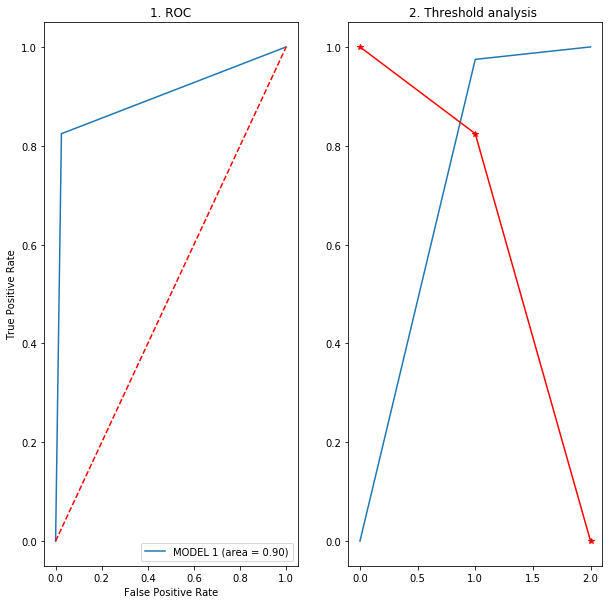

Prediction for model 1:
Confusion Matrix
[[291  26]
 [ 93 761]]
Classification Report
              precision    recall  f1-score   support

           1       0.76      0.92      0.83       317
           0       0.97      0.89      0.93       854

   micro avg       0.90      0.90      0.90      1171
   macro avg       0.86      0.90      0.88      1171
weighted avg       0.91      0.90      0.90      1171



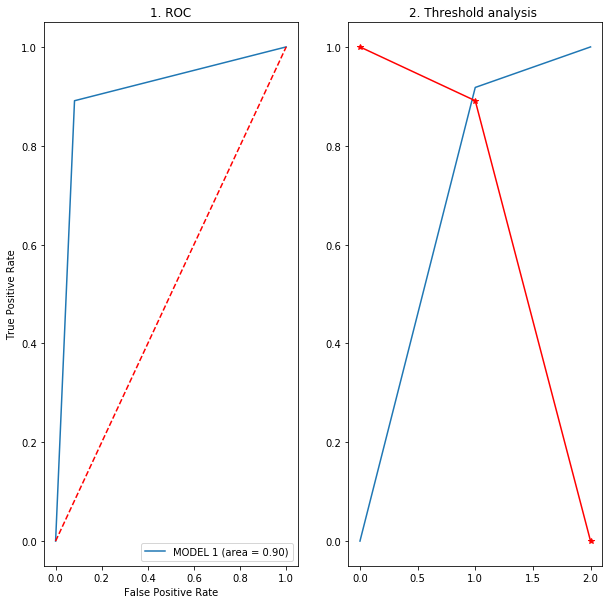

Prediction for model 2:
Confusion Matrix
[[ 32 285]
 [  4 850]]
Classification Report
              precision    recall  f1-score   support

           1       0.89      0.10      0.18       317
           0       0.75      1.00      0.85       854

   micro avg       0.75      0.75      0.75      1171
   macro avg       0.82      0.55      0.52      1171
weighted avg       0.79      0.75      0.67      1171



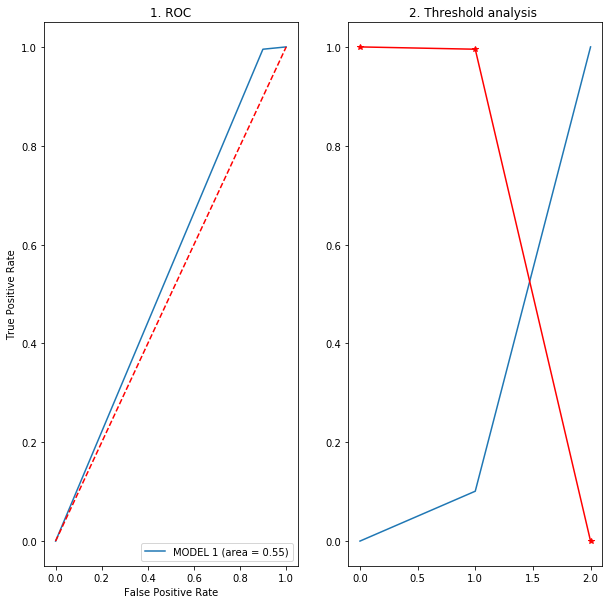

In [33]:
evaluation(0.5)


In [ ]:
# What for??
#sensitivity at specificity? sensitivity 
Y_labels = Y_labels.reshape(1171,)
Y_pred = Y_pred.reshape(1171,)
m = tf.keras.metrics.SensitivityAtSpecificity(0.9, num_thresholds = 1)
m.update_state(Y_labels, Y_pred)
m.result().numpy()